# CORD-19 data challenge

In [9]:
import numpy as np
import pandas as pd
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [10]:
import bert_serving.client as cli
from bert_serving.client import BertClient
bc = BertClient(ip='localhost',check_length=False)
str1 = 'first i want to do this and next that one. '
for i in range(300):
    str1 += 'first i want to do this and next that one.'
vecs = bc.encode(['First do it', 'then do it right', 'then do it better',str1])
print(len(vecs),[len(i) for i in vecs])
print(cli.__version__)

4 [768, 768, 768, 768]
1.9.9


## 1. Load data

In [11]:
# # Code from literature clustering project
# root_path = 'data/CORD-19-research-challenge/'
# metadata_path = f'{root_path}/metadata.csv'
# meta_df = pd.read_csv(metadata_path, dtype={
#     'pubmed_id': str,
#     'Microsoft Academic Paper ID': str, 
#     'doi': str
# })
# meta_df.head()

FileNotFoundError: [Errno 2] File b'data/CORD-19-research-challenge//metadata.csv' does not exist: b'data/CORD-19-research-challenge//metadata.csv'

# Approach:

- Parse the text from the body of each document using Natural Language Processing (NLP).
- Turn each document instance $d_i$ into a feature vector $X_i$ using Term Frequency–inverse Document Frequency (TF-IDF).
- Apply Dimensionality Reduction to each feature vector $X_i$ using t-Distributed Stochastic Neighbor Embedding (t-SNE) to cluster similar research articles in the two dimensional plane $X$ embedding $Y_1$.
- Use Principal Component Analysis (PCA) to project down the dimensions of $X$ to a number of dimensions that will keep .95 variance while removing noise and outliers in embedding $Y_2$.
- Apply k-means clustering on $Y_2$, where $k$ is 20, to label each cluster on $Y_1$.
- Apply Topic Modeling on $X$ using Latent Dirichlet Allocation (LDA) to discover keywords from each cluster. 
- Investigate the clusters visually on the plot, zooming down to specific articles as needed, and via classification using Stochastic Gradient Descent (SGD). 

<br>

# Table of Contents
1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Dimensionality Reduction with t-SNE
6. Topic Modeling on Each Cluster
7. Classify
8. Plot
9. How to Use the Plot?
10. Conclusion
11. Citation/Sources

<br>

# Loading the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json


import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [13]:
root_path = 'data/cord19'
metadata_path = '{}/metadata.csv'.format(root_path)
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/home/felix/anaconda3/envs/sparc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,8q5ondtn,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(72)90077-4
1,pzfd0e50,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90355-5
2,22bka3gi,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90356-7
3,zp9k1k3z,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/0002-9343(73)90176-9
4,cjuzul89,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-9343(85)90361-4


In [14]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47298 entries, 0 to 47297
Data columns (total 18 columns):
cord_uid                       47298 non-null object
sha                            34283 non-null object
source_x                       47298 non-null object
title                          47140 non-null object
doi                            43956 non-null object
pmcid                          28038 non-null object
pubmed_id                      35409 non-null object
license                        47298 non-null object
abstract                       39048 non-null object
publish_time                   47289 non-null object
authors                        45189 non-null object
journal                        42894 non-null object
Microsoft Academic Paper ID    964 non-null object
WHO #Covidence                 1768 non-null object
has_pdf_parse                  47298 non-null bool
has_pmc_xml_parse              47298 non-null bool
full_text_file                 38469 non-null obje

### Fetch All of JSON File Path

Get path to all JSON files:

In [15]:
all_json = glob.glob('{}/**/*.json'.format(root_path), recursive=True)
len(all_json)

52097

### Helper Functions

 File Reader Class

In [16]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return '{}: {}... {}...'.format(self.paper_id,self.abstract[:200],self.body_text[:200])
first_row = FileReader(all_json[0])
print(first_row)

fc363739ad7ec8d796aba6af478d986a4c0f5f3f: In recent years, many studies have reported potential associations between cytokine gene polymorphisms and the development, course, and outcome of sepsis, often with apparently conflicting results. Th... Sepsis is a host condition of systemic inappropriate inflammatory response to the invasion of microorganisms [1] . Although there are many advances in the development of antibiotics and there has been...


Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [17]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [18]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print('Processing index: {} of {}'.format(idx,len(all_json)))
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 52097
Processing index: 5209 of 52097
Processing index: 10418 of 52097
Processing index: 15627 of 52097
Processing index: 20836 of 52097
Processing index: 26045 of 52097
Processing index: 31254 of 52097
Processing index: 36463 of 52097
Processing index: 41672 of 52097
Processing index: 46881 of 52097
Processing index: 52090 of 52097


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,fc363739ad7ec8d796aba6af478d986a4c0f5f3f,10.5114/ceji.2015.50836,"In recent years, many studies have reported po...",Sepsis is a host condition of systemic inappro...,"Allam, Gamal. Alsulaimani, Adnan A.. <br>Alz...",Neonatal infections in Saudi Arabia:<br>Assoc...,Cent Eur J Immunol,"In recent years, many studies have reported<b..."
1,6ff336c5f099acbe84cf7cfe5f68bd5ba672d6b8,10.1292/jvms.15-0723,The objective was to investigate porcine epide...,Porcine epidemic diarrhea (PED) was first repo...,"YAMANE, Itsuro. YAMAZAKI, Hisanori. <br>ISHI...",Impact of a porcine epidemic diarrhea outbrea...,J Vet Med Sci,The objective was to investigate porcine<br>e...
2,cb5a49679732abf852dec6e61e435602706289c3,10.1128/mbio.01331-14,"In March 2013, three fatal human cases of infe...","mitted, albeit inefficiently, via respiratory ...","de Wit, Emmie. Rasmussen, Angela L.. Feldma...",Influenza Virus A/Anhui/1/2013 (H7N9)<br>Repl...,mBio,"In March 2013, three fatal human cases of<br>..."
3,76bbd67d210cfbd619123b103b0aa1966857b75a,10.2147/tcrm.s38872,The People's Republic of China has nearly the ...,The incidences of diabetes mellitus (DM) and t...,"Wang, Hong-Tian. Zhang, Jing. Ji, Ling-Chao...",Frequency of tuberculosis among diabetic<br>p...,Ther Clin Risk Manag,The People's Republic of China has nearly the...
4,78656ac2a77d7d0b6487b2f5b97d1bc59ec49ee5,10.1007/s11427-011-4177-7,Viruses replicate and proliferate in host cell...,Viruses are not only notorious for their patho...,"Zhou, ShengTao. Liu, Rui. Zhao, Xia. Huang...",Viral proteomics: The emerging cutting-edge<b...,Sci China Life Sci,Viruses replicate and proliferate in host<br>...


## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [19]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,fc363739ad7ec8d796aba6af478d986a4c0f5f3f,10.5114/ceji.2015.50836,"In recent years, many studies have reported po...",Sepsis is a host condition of systemic inappro...,"Allam, Gamal. Alsulaimani, Adnan A.. <br>Alz...",Neonatal infections in Saudi Arabia:<br>Assoc...,Cent Eur J Immunol,"In recent years, many studies have reported<b...",204,4032,1218
1,6ff336c5f099acbe84cf7cfe5f68bd5ba672d6b8,10.1292/jvms.15-0723,The objective was to investigate porcine epide...,Porcine epidemic diarrhea (PED) was first repo...,"YAMANE, Itsuro. YAMAZAKI, Hisanori. <br>ISHI...",Impact of a porcine epidemic diarrhea outbrea...,J Vet Med Sci,The objective was to investigate porcine<br>e...,213,2428,825
2,cb5a49679732abf852dec6e61e435602706289c3,10.1128/mbio.01331-14,"In March 2013, three fatal human cases of infe...","mitted, albeit inefficiently, via respiratory ...","de Wit, Emmie. Rasmussen, Angela L.. Feldma...",Influenza Virus A/Anhui/1/2013 (H7N9)<br>Repl...,mBio,"In March 2013, three fatal human cases of<br>...",359,5121,1672
3,76bbd67d210cfbd619123b103b0aa1966857b75a,10.2147/tcrm.s38872,The People's Republic of China has nearly the ...,The incidences of diabetes mellitus (DM) and t...,"Wang, Hong-Tian. Zhang, Jing. Ji, Ling-Chao...",Frequency of tuberculosis among diabetic<br>p...,Ther Clin Risk Manag,The People's Republic of China has nearly the...,195,2277,894
4,78656ac2a77d7d0b6487b2f5b97d1bc59ec49ee5,10.1007/s11427-011-4177-7,Viruses replicate and proliferate in host cell...,Viruses are not only notorious for their patho...,"Zhou, ShengTao. Liu, Rui. Zhao, Xia. Huang...",Viral proteomics: The emerging cutting-edge<b...,Sci China Life Sci,Viruses replicate and proliferate in host<br>...,148,5743,1959


In [20]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32417 entries, 0 to 32416
Data columns (total 11 columns):
paper_id               32417 non-null object
doi                    32103 non-null object
abstract               32417 non-null object
body_text              32417 non-null object
authors                31847 non-null object
title                  32381 non-null object
journal                31003 non-null object
abstract_summary       32417 non-null object
abstract_word_count    32417 non-null int64
body_word_count        32417 non-null int64
body_unique_words      32417 non-null int64
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


In [21]:
df_covid['abstract'].describe(include='all')

count     32417
unique    24098
top            
freq       8280
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [22]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     32402
unique    24098
top            
freq       8272
Name: abstract, dtype: object

In [23]:
df_covid['body_text'].describe(include='all')

count                                                 32402
unique                                                32401
top       In a global world, knowledge of imported infec...
freq                                                      2
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [24]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,fc363739ad7ec8d796aba6af478d986a4c0f5f3f,10.5114/ceji.2015.50836,"In recent years, many studies have reported po...",Sepsis is a host condition of systemic inappro...,"Allam, Gamal. Alsulaimani, Adnan A.. <br>Alz...",Neonatal infections in Saudi Arabia:<br>Assoc...,Cent Eur J Immunol,"In recent years, many studies have reported<b...",204,4032,1218
1,6ff336c5f099acbe84cf7cfe5f68bd5ba672d6b8,10.1292/jvms.15-0723,The objective was to investigate porcine epide...,Porcine epidemic diarrhea (PED) was first repo...,"YAMANE, Itsuro. YAMAZAKI, Hisanori. <br>ISHI...",Impact of a porcine epidemic diarrhea outbrea...,J Vet Med Sci,The objective was to investigate porcine<br>e...,213,2428,825
2,cb5a49679732abf852dec6e61e435602706289c3,10.1128/mbio.01331-14,"In March 2013, three fatal human cases of infe...","mitted, albeit inefficiently, via respiratory ...","de Wit, Emmie. Rasmussen, Angela L.. Feldma...",Influenza Virus A/Anhui/1/2013 (H7N9)<br>Repl...,mBio,"In March 2013, three fatal human cases of<br>...",359,5121,1672
3,76bbd67d210cfbd619123b103b0aa1966857b75a,10.2147/tcrm.s38872,The People's Republic of China has nearly the ...,The incidences of diabetes mellitus (DM) and t...,"Wang, Hong-Tian. Zhang, Jing. Ji, Ling-Chao...",Frequency of tuberculosis among diabetic<br>p...,Ther Clin Risk Manag,The People's Republic of China has nearly the...,195,2277,894
4,78656ac2a77d7d0b6487b2f5b97d1bc59ec49ee5,10.1007/s11427-011-4177-7,Viruses replicate and proliferate in host cell...,Viruses are not only notorious for their patho...,"Zhou, ShengTao. Liu, Rui. Zhao, Xia. Huang...",Viral proteomics: The emerging cutting-edge<b...,Sci China Life Sci,Viruses replicate and proliferate in host<br>...,148,5743,1959


In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [25]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,32402.000000,32402.000000,32402.000000
mean,165.028856,4727.010185,1426.398617
std,171.208276,7131.584556,1185.174376
min,0.000000,1.000000,1.000000
25%,0.000000,2425.250000,911.000000
50%,163.000000,3675.000000,1243.000000
75%,237.000000,5435.000000,1667.000000
max,4767.000000,260378.000000,38298.000000


# Data Pre-processing

Unfortunately, running the next steps of the notebook is not possible on the full dataset within Kaggle. The full plot is available is at https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html.

In Kaggle we will limit the dataframe to **10,000** instances

In [26]:
df = df_covid.sample(10000, random_state=42)
del df_covid

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [27]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9299 entries, 25335 to 20701
Data columns (total 11 columns):
paper_id               9299 non-null object
doi                    9299 non-null object
abstract               9299 non-null object
body_text              9299 non-null object
authors                9299 non-null object
title                  9299 non-null object
journal                9299 non-null object
abstract_summary       9299 non-null object
abstract_word_count    9299 non-null int64
body_word_count        9299 non-null int64
body_unique_words      9299 non-null int64
dtypes: int64(3), object(8)
memory usage: 871.8+ KB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [28]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 9299/9299 [00:41<00:00, 225.97it/s]


In [29]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 9299

{'af': 1,
 'cy': 1,
 'de': 14,
 'en': 9086,
 'es': 95,
 'fr': 86,
 'it': 6,
 'nl': 2,
 'pl': 1,
 'pt': 7}


Lets take a look at the language distribution in the dataset

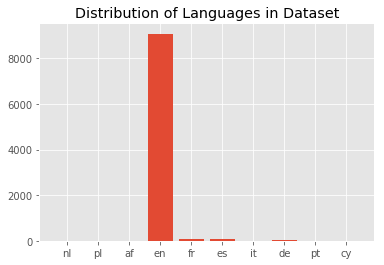

In [30]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [31]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9086 entries, 25335 to 20701
Data columns (total 12 columns):
paper_id               9086 non-null object
doi                    9086 non-null object
abstract               9086 non-null object
body_text              9086 non-null object
authors                9086 non-null object
title                  9086 non-null object
journal                9086 non-null object
abstract_summary       9086 non-null object
abstract_word_count    9086 non-null int64
body_word_count        9086 non-null int64
body_unique_words      9086 non-null int64
language               9086 non-null object
dtypes: int64(3), object(9)
memory usage: 922.8+ KB


In [32]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [33]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [34]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['‘ve',
 'further',
 'no',
 'in',
 'whereupon',
 'due',
 'four',
 'into',
 'this',
 'amount']

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [35]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [36]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Applying the text-processing function on the **body_text**. 

In [37]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

100%|██████████| 9086/9086 [1:25:07<00:00,  1.78it/s]  


In [38]:
import seaborn as sns

count      9086.000000
mean       4538.670042
std        4232.082185
min          12.000000
25%        2552.000000
50%        3758.500000
75%        5462.000000
max      100442.000000
Name: body_word_count, dtype: float64

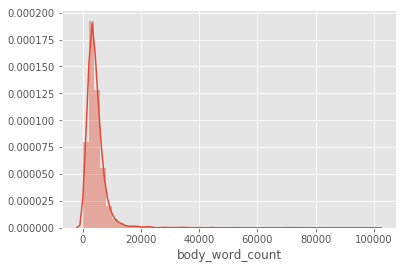

In [35]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

## Bert Embedding

In [49]:
# print body text and abstract
print(type(df["body_text"]),df["body_text"].shape,type(df["body_text"].iloc[0]),df["abstract"].iloc[0])

<class 'pandas.core.series.Series'> (9086,) <class 'str'> The coronavirus nucleocapsid (N) protein binds viral RNA to form the ribonucleocapsid and regulate RNA synthesis. The interaction of N protein with viral RNA was investigated using circular dichroism and surface plasmon resonance. N protein underwent a conformational change upon binding viral RNA and the data indicated electrostatic interactions were involved in the binding of the protein to RNA. Kinetic analysis suggested the amino-terminal region facilitates long-range non-specific interactions between N protein and viral RNA, thus bringing the RNA into close proximity to N protein allowing specific contacts to form via a 'lure' and 'lock' mechanism.


In [52]:
body_text = df["body_text"].array
abstract = df["abstract"].array
assert len(body_text) == len(abstract)
print(len(body_text))

9086


In [56]:
paragraph = body_text[0].split('\n')
print(paragraph)

AttributeError: 'list' object has no attribute 'tolist'

In [68]:
text_list = df["body_text"].tolist()
abs_list = df["abstract"].tolist()

text = []
abst = []
for i in range(len(text_list)):
    if len(text_list[i]) > 0 and len(abs_list[i]) > 0:
        text.append(text_list[i])
        abst.append(abs_list[i])
# print(abs_list[:5])
# vecs = bc.encode(abs_list)
text_split = []
for i in text:
    text_split.append(i.split('\n'))

In [69]:
print(len(text),len(text_split))

6834 6834


In [75]:
from tqdm import tqdm

In [76]:
vec_abst = bc.encode(abst)
# vec_abst = bc.encode(text)
vec_text_split = []
for i in tqdm(range(len(text_split))):
    vec_text_split.append(bc.encode(text_split[i]))

100%|██████████| 6834/6834 [11:59<00:00,  9.50it/s]


In [78]:
from sklearn.metrics.pairwise import cosine_similarity

In [85]:
pos_avg = []
neg_avg = []

x1 = np.array(vec_abst[:5])
x2 = [[np.array(i) for i in j] for j in vec_text_split[:5]]
for i in range(5):
    tmp1 = [cosine_similarity(x1[i,:].reshape(1,-1),j.reshape(1,-1)) for j in x2[i]]
    pos_avg.append(sum(tmp1)/len(tmp1))
    tmp2 = []
    for j in range(5):
        if i != j:
            tmp2 += x2[j]
    print(len(tmp2),tmp2[0].shape)
    tmp2 = [cosine_similarity(x1[i,:].reshape(1,-1),j.reshape(1,-1)) for j in tmp2]
    
    neg_avg.append(sum(tmp2)/len(tmp2))
    
print(pos_avg)
print(neg_avg)

72 (768,)
57 (768,)
79 (768,)
84 (768,)
72 (768,)
[array([[0.9134934]], dtype=float32), array([[0.92645514]], dtype=float32), array([[0.9287059]], dtype=float32), array([[0.93304384]], dtype=float32), array([[0.9223081]], dtype=float32)]
[array([[0.9167254]], dtype=float32), array([[0.9253364]], dtype=float32), array([[0.92734027]], dtype=float32), array([[0.8962527]], dtype=float32), array([[0.9095463]], dtype=float32)]


In [130]:
import torch
import random
from random import randint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils
from torch.autograd import Variable
import torch.optim as optim

In [133]:
def data_gen(vec_abst,vec_text_split,neg_num=12):
    result = []
    for i in range(len(vec_abst)):
        neg_samples = np.random.randint(0,high=len(vec_abst),size=neg_num).tolist()
        if i in neg_samples:
            neg_samples.remove(i) 
        result.append(neg_samples)
    
    return result

    
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def check_type_forward(self, in_types):
        assert len(in_types) == 3

        x0_type, x1_type, y_type = in_types
        assert x0_type.size() == x1_type.shape
        assert x1_type.size()[0] == y_type.shape[0]
        assert x1_type.size()[0] > 0
        assert x0_type.dim() == 2
        assert x1_type.dim() == 2
        assert y_type.dim() == 1

    def forward(self, x0, x1, y):
        self.check_type_forward((x0, x1, y))

        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss
    
class EmbedModel(nn.Module):
    def __init__(self, embeddings, text_embeddings ,input_dim, hidden_dim=3200 , output_dim=1600,dropout=0.3):
        super(EmbedModel, self).__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)
        self.nl = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.embeddings = embeddings
        self.body_embeds = text_embeddings
        self.loss = ContrastiveLoss()
        
    def encode(self,embeds):
        out = self.l2(self.nl(self.l1(embeds)))
        return out
    def forward(self,X,neg_samples):
        loss = 0
        for idx_e,ind_e in enumerate(X):
            neg_embed = [ self.body_embeds[n][ind_n % self.body_embeds[n].size()[0],:].view(1,-1) for ind_n,n in enumerate(neg_samples[idx_e])]
            neg_embed.append(body_embeds[ind_e])
            neg_embed = torch.cat(neg_embed,dim=0)
            neg_embed = self.encode(neg_embed)
            
            Y = torch.zeros(neg_embed.size()[0])
            Y[-len(body_embeds[ind_e]):] = 1
            
            x0 = self.embeddings[idx_e,:].view(1,-1)
            x0 = self.encode(x0)
            x0 = torch.cat(neg_embed.size()[0]*[x0],dim=0)
#             print(x0.size(),neg_embed.size(),Y.size())
            loss += self.loss(x0,neg_embed,Y)
            
        return loss
            
         

In [135]:
epoches = 20
batch = 32
lr = 0.00015

embedding = torch.FloatTensor(vec_abst)
body_embeds = [torch.FloatTensor(i) for i in vec_text_split]
model = EmbedModel(embedding,body_embeds,768)
optimizer = optim.Adam(model.parameters(), lr=lr)
for e in range(epoches):
    sample = data_gen(vec_abst,vec_text_split,neg_num=6)
    idx_e = 0
    loss_epoch = 0
    while idx_e < len(sample):
        optimizer.zero_grad()
        
        x = sample[idx_e:min(idx_e+batch,len(sample))]
        assert len(list(range(idx_e,min(idx_e+batch,len(sample))))) == len(x), print(len(x),idx_e)
        loss = model.forward(list(range(idx_e,min(idx_e+batch,len(sample)))),x)
        loss.backward()
        optimizer.step()
        
        if idx_e % 800 == 0:
            print('Epoch',e, "iter", idx_e, 'Loss', loss)
        idx_e += batch
        loss_epoch +=  loss / batch
        

Epoch 0 iter 0 Loss tensor(93.5539, grad_fn=<AddBackward0>)
Epoch 0 iter 800 Loss tensor(13.7524, grad_fn=<AddBackward0>)
Epoch 0 iter 1600 Loss tensor(8.2053, grad_fn=<AddBackward0>)
Epoch 0 iter 2400 Loss tensor(6.0511, grad_fn=<AddBackward0>)
Epoch 0 iter 3200 Loss tensor(4.9908, grad_fn=<AddBackward0>)
Epoch 0 iter 4000 Loss tensor(4.2253, grad_fn=<AddBackward0>)
Epoch 0 iter 4800 Loss tensor(3.8324, grad_fn=<AddBackward0>)
Epoch 0 iter 5600 Loss tensor(3.3944, grad_fn=<AddBackward0>)
Epoch 0 iter 6400 Loss tensor(3.1260, grad_fn=<AddBackward0>)
Epoch 1 iter 0 Loss tensor(3.0832, grad_fn=<AddBackward0>)
Epoch 1 iter 800 Loss tensor(3.0719, grad_fn=<AddBackward0>)
Epoch 1 iter 1600 Loss tensor(2.9095, grad_fn=<AddBackward0>)
Epoch 1 iter 2400 Loss tensor(2.6392, grad_fn=<AddBackward0>)
Epoch 1 iter 3200 Loss tensor(2.6536, grad_fn=<AddBackward0>)
Epoch 1 iter 4000 Loss tensor(2.7707, grad_fn=<AddBackward0>)
Epoch 1 iter 4800 Loss tensor(2.7398, grad_fn=<AddBackward0>)
Epoch 1 iter 5

In [138]:
from sklearn.decomposition import PCA

X = model.encode(embedding).detach().numpy()
print(X.shape)
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X)
X_reduced.shape

(6834, 1600)


(6834, 143)

In [140]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

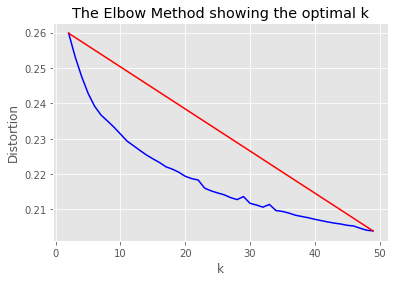

In [141]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [142]:
# Run kmeans

k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)


In [143]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 6834 samples in 0.805s...
[t-SNE] Computed neighbors for 6834 samples in 107.649s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6834
[t-SNE] Computed conditional probabilities for sample 2000 / 6834
[t-SNE] Computed conditional probabilities for sample 3000 / 6834
[t-SNE] Computed conditional probabilities for sample 4000 / 6834
[t-SNE] Computed conditional probabilities for sample 5000 / 6834
[t-SNE] Computed conditional probabilities for sample 6000 / 6834
[t-SNE] Computed conditional probabilities for sample 6834 / 6834
[t-SNE] Mean sigma: 0.071252
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.293488
[t-SNE] KL divergence after 1000 iterations: 2.060642


So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

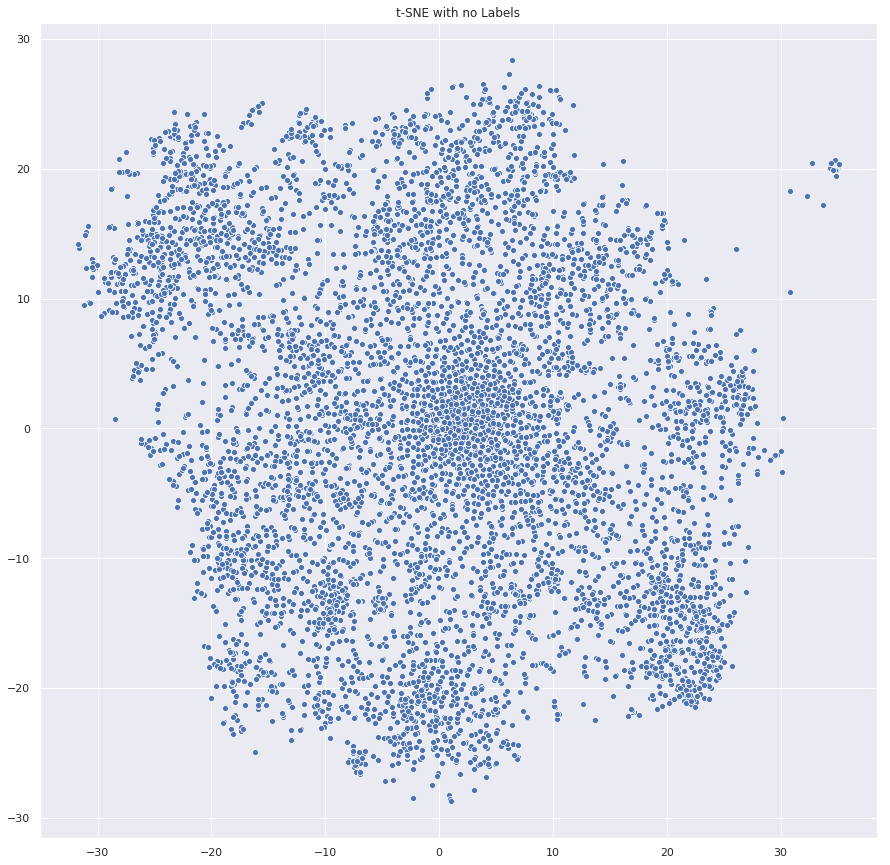

In [144]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

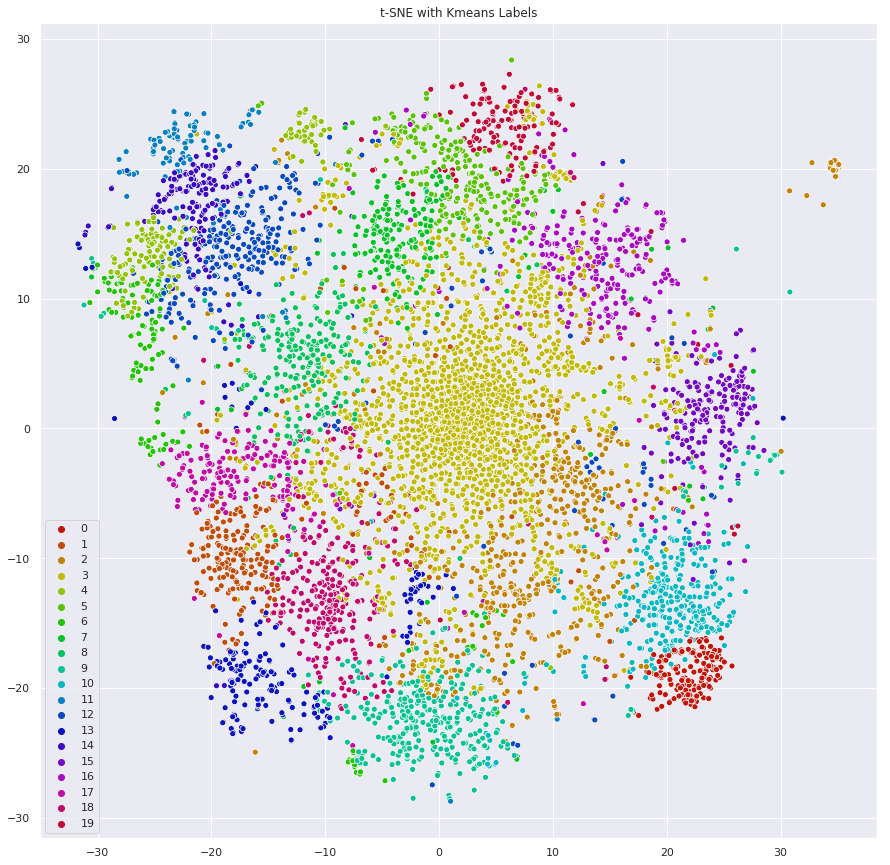

In [145]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()